In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import copy
import pynumdiff

2024-04-11 10:04:45,233 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [2]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [3]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g



# Desired trajectory

In [4]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 2+np.sin(0.005*t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [5]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)
    
    return F, tau

In [6]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # control
    F, tau = control(X, t)
    
    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m
    
    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
    
    return d_x

# Run simulation

In [7]:
t = np.arange(0, 1500, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f, x0, t)
X = result.T

# Plot results

In [8]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

thetadot = X[1, :]
xdot = X[3, :]
zdot = X[5, :]

theta_des, x_des, z_des = desired_trajectory(t)

<Axes: xlabel='Time', ylabel='z'>

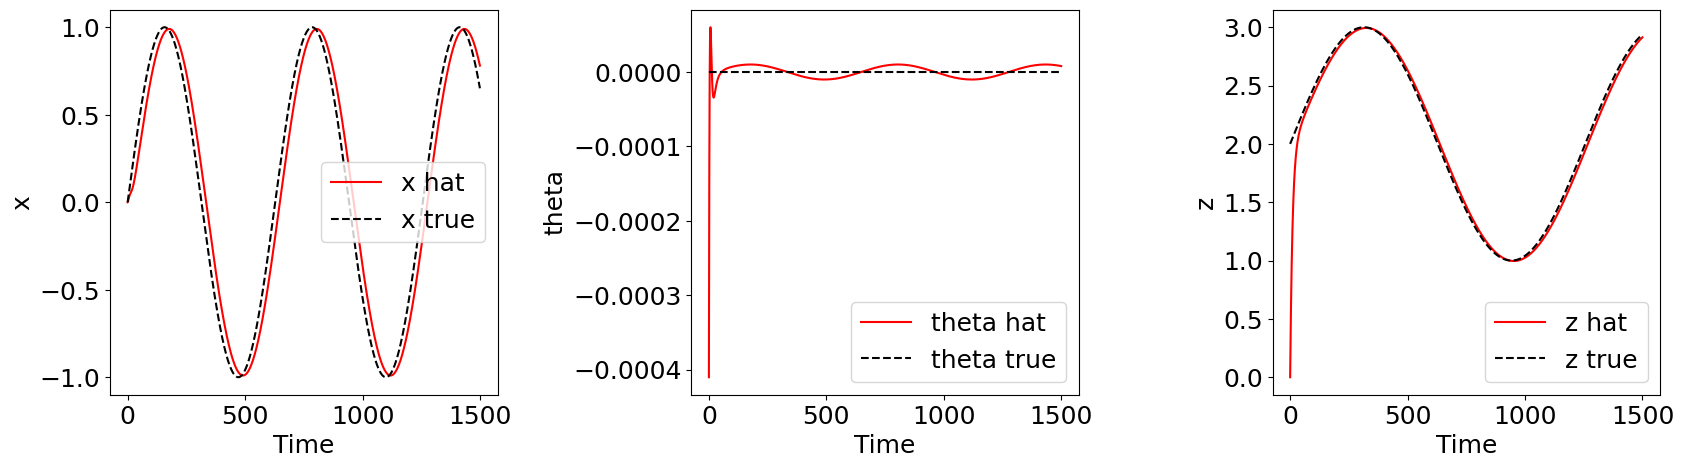

In [9]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [10]:
# Noise for measurements: (standard deviations)
v = np.array([0.01, 0.2, 0.2])

def h(X, v, t):
    theta, thetadot, x, xdot, z, zdot = X
    F, tau = control(X, t)
    
    #xddot_direct = -F*np.sin(theta)/m
    #zddot_direct = (F*np.cos(theta)-m*g)/m
    
    y = np.array([theta, x, z]) #, xddot_direct, zddot_direct])
    
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [11]:
Y = np.vstack( [h(X[:,i], v, t[i]) for i in range(X.shape[1]) ] ).T

<Axes: xlabel='Time', ylabel='z'>

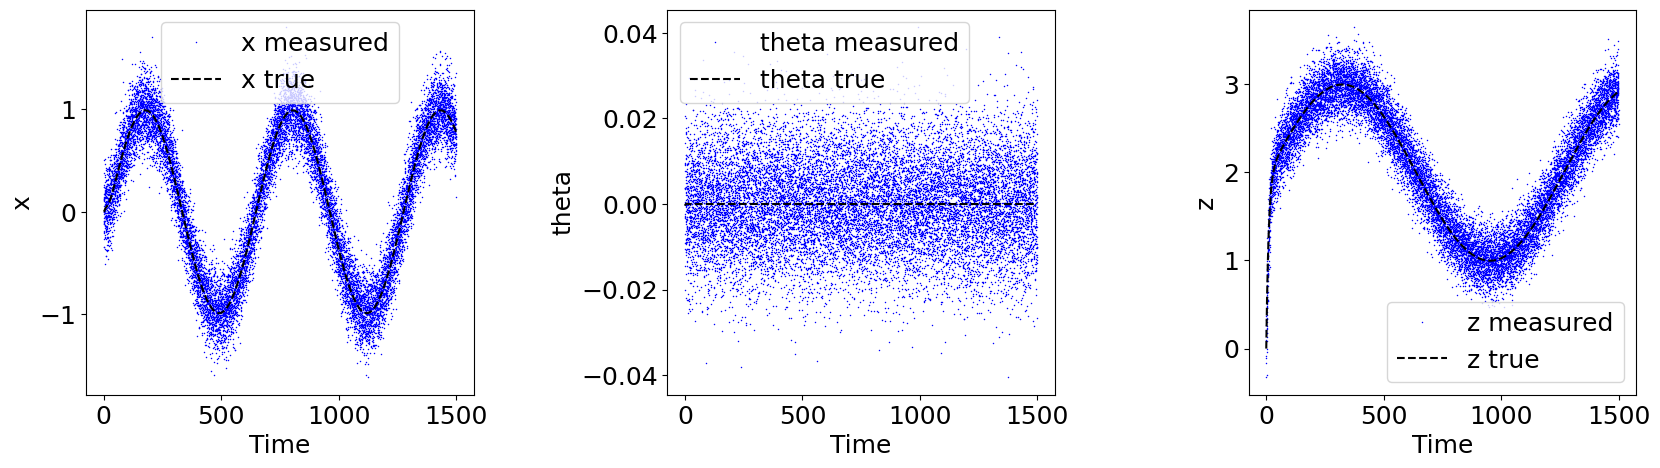

In [12]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[1,:], None, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[2,:], None, label_var='z', ax=ax3)

# Controls

In [13]:
def control_linear(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot) - F0
    
    return F, tau

In [14]:
u = control_linear(X, t)
u = np.vstack(u)

In [15]:
dt = np.mean(np.diff(t))

# Noisy measurements

In [17]:
w = np.array([0.01, 0.001, 0.2, 0.002, 0.2, 0.002])
Xnoisy = copy.copy(X)
for i in range(len(w)):
    Xnoisy[i,:] += np.random.normal(0, w[i], Xnoisy.shape[1])

# Remove some noise

In [18]:
import pynumdiff

In [28]:
Yaug = copy.copy(Y)
for i in range(3):
    y_smooth, y_deriv = pynumdiff.linear_model.savgoldiff(Yaug[i,:], dt, [2, 200, 200])
    Yaug = np.vstack((Yaug, y_smooth, y_deriv))
    y_smooth, y_deriv = pynumdiff.linear_model.savgoldiff(Yaug[i,:], dt, [2, 300, 300])
    Yaug = np.vstack((Yaug, y_smooth, y_deriv))
    y_smooth, y_deriv = pynumdiff.linear_model.savgoldiff(Yaug[i,:], dt, [2, 400, 400])
    Yaug = np.vstack((Yaug, y_smooth, y_deriv))
    y_smooth, y_deriv = pynumdiff.linear_model.savgoldiff(Yaug[i,:], dt, [2, 600, 600])
    Yaug = np.vstack((Yaug, y_smooth, y_deriv))
    y_smooth, y_deriv = pynumdiff.linear_model.savgoldiff(Yaug[i,:], dt, [2, 800, 800])
    Yaug = np.vstack((Yaug, y_smooth, y_deriv))
    y_smooth, y_deriv = pynumdiff.linear_model.savgoldiff(Yaug[i,:], dt, [2, 1000, 1000])
    Yaug = np.vstack((Yaug, y_smooth, y_deriv))
    y_smooth, y_deriv = pynumdiff.linear_model.savgoldiff(Yaug[i,:], dt, [2, 1200, 1200])
    Yaug = np.vstack((Yaug, y_smooth, y_deriv))

In [27]:
start = 10
end = 10000

# Relation from Augmented measurements to the state variables

This is something you have to know. Here we calculate it, since we know C, but it could be determined from first principles. If you can't get this, then there is no way to know what the state is that you want to extract. 

In [29]:
Ctostate = Yaug[:,start:end]@np.linalg.pinv(X[:,start:end])

# Dynamic Mode Decomposition

In [30]:
X0 = Yaug[:,start:end-1]
Xf = Yaug[:,start+1:end]
Omega = np.vstack((X0, u[:,0:X0.shape[1]]))

In [31]:
U0, E0, Vt0 = np.linalg.svd(Omega, full_matrices=False)

rank:  17


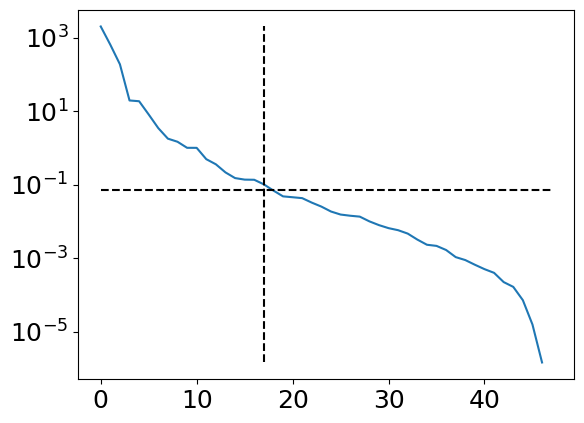

In [32]:
# optimal singular value cutoff
singvalthresh = 2.858*np.median(E0)
r = np.where(E0>singvalthresh)[0][-1]
print('rank: ', r)

plt.plot(E0)
plt.yscale('log')
plt.hlines(singvalthresh, 0, len(E0), linestyles='--', color='black')
plt.vlines(r, np.min(E0), np.max(E0), linestyles='--', color='black')

In [33]:
U0r = U0[:,0:r]
E0r = np.diag(E0[0:r])
V0r = Vt0.T[:,0:r]

In [34]:
Uf, Ef, Vtf = np.linalg.svd(Xf, full_matrices=False)
Ufr = Uf[:,0:r]
Efr = np.diag(Ef[0:r])
Vfr = Vtf.T[:,0:r]

In [35]:
Am = Ufr.T@Xf@V0r@np.linalg.inv(E0r)@U0r[0:-u.shape[0],:].T@Ufr
Bm = Ufr.T@Xf@V0r@np.linalg.inv(E0r)@U0r[-u.shape[0]:,:].T

In [36]:
Ur = U0r[0:-u.shape[0],:]

In [37]:
Ym = Ufr.T@Yaug

In [38]:
Cm = Ufr.T@np.eye(Yaug.shape[0])@Ufr

# Organize some inputs for the KF

In [39]:
# R is determined by the variance, thus the square of the standard deviation
R = 1e-3*np.eye(Ym.shape[0])

# Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
# But they can be led astray, and are slower to converge 
#Q = 1e5*np.diag(w)**2
Q = 1e-7*np.eye(Am.shape[0])

# initial state estimate
x0 = [(np.random.random()-0.5)*20 for i in range(Am.shape[0])]
x0 = np.atleast_2d(x0).T

# initial covariance estimate
P0 = 10*np.eye(Am.shape[0])

# Run the KF

In [40]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [41]:
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [42]:
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Ym, u, Am, Bm, Cm, R, Q)

In [43]:
xhat_fp = Ufr@xhat_fp

In [44]:
xhat_fp = np.linalg.pinv(Ctostate)@xhat_fp

In [45]:
theta_hat = xhat_fp[0, :]
thetadot_hat = xhat_fp[1, :]
x_hat = xhat_fp[2, :]
xdot_hat = xhat_fp[3, :]
z_hat = xhat_fp[4, :]
zdot_hat = xhat_fp[5, :]

In [46]:
end = xhat_fp.shape[1]

(0.0, 4.0)

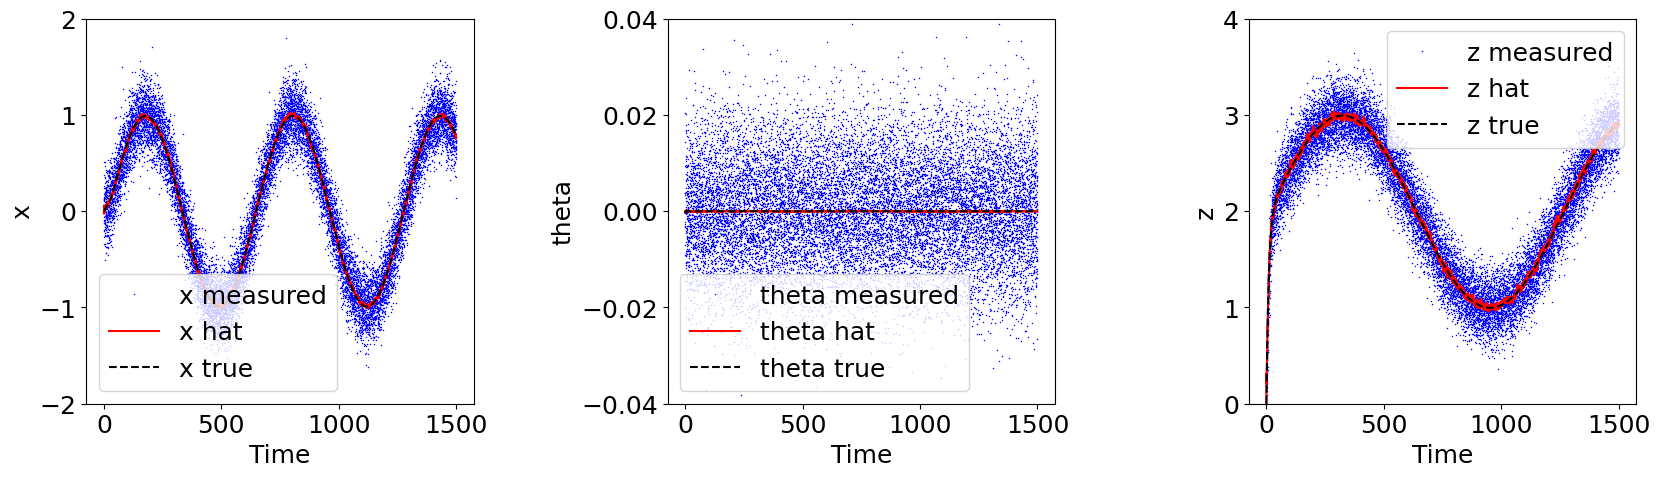

In [47]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t[0:end], x[0:end], Y[1,0:end], x_hat[0:end], label_var='x', ax=ax1)
ax1.set_ylim(-2,2)

ax2 = fig.add_subplot(132)
plot_tme(t[0:end], theta[0:end], Y[0,0:end], theta_hat[0:end], label_var='theta', ax=ax2)
ax2.set_ylim(-0.04,0.04)

ax3 = fig.add_subplot(133)
plot_tme(t[0:end], z[0:end], Y[2,0:end], z_hat[0:end], label_var='z', ax=ax3)
ax3.set_ylim(0, 4)

(-0.05, 0.05)

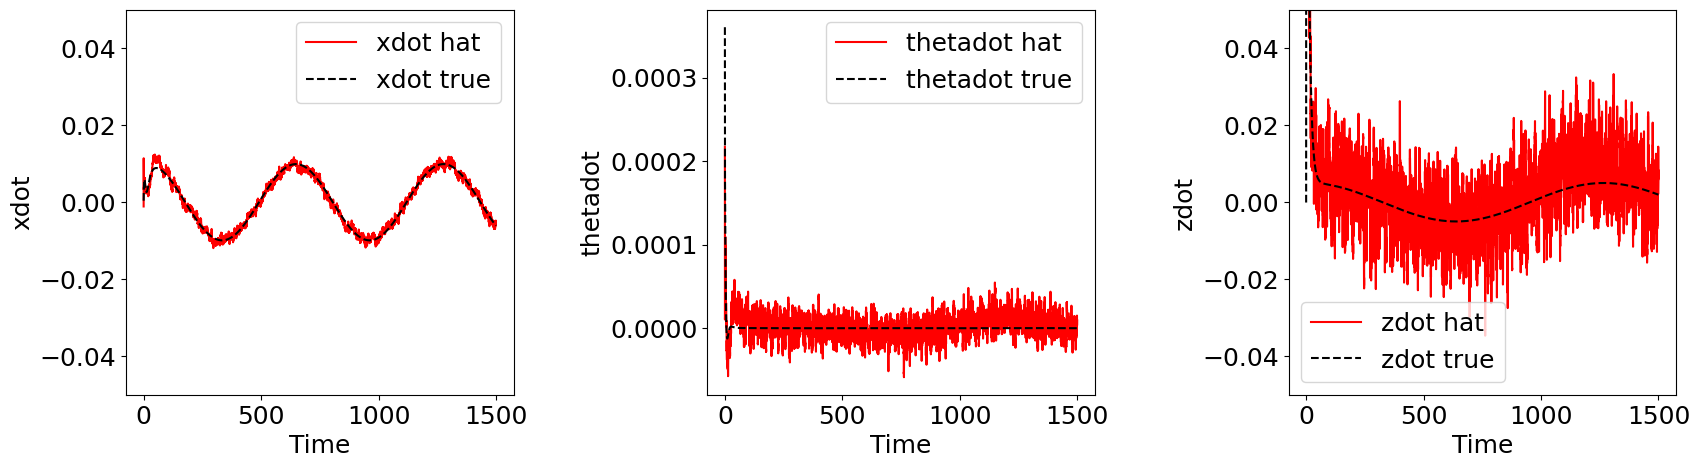

In [48]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t[0:end], xdot[0:end], None, xdot_hat[0:end], label_var='xdot', ax=ax1)
ax1.set_ylim(-.05, 0.05)

ax2 = fig.add_subplot(132)
plot_tme(t[0:end], thetadot[0:end], None, thetadot_hat[0:end], label_var='thetadot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t[0:end], zdot[0:end], None, zdot_hat[0:end], label_var='zdot', ax=ax3)
ax3.set_ylim(-.05, 0.05)

# Excercise

1. Change the measurements to be nonlinear, e.g. $h = [\theta, x+z, x \cdot z]$
2. Can you still estimate the states using a DMD model?